In [21]:
import nibabel as nib
import numpy as np

def load_non_overlapping_nifti(image_path, label_path, desired_labels=[3,4,5,6,7,8,9,10,11]):

    img = nib.load(image_path)
    lbl = nib.load(label_path)

    img_np = img.get_fdata().astype(np.float32)
    lbl_np = lbl.get_fdata().astype(np.uint64)

    affine = img.affine
    spacing = np.linalg.norm(affine[:3, :3], axis=0)

    # Remap our bitmask labels to a compact range starting from 1
    remapped_lbl = np.zeros_like(lbl_np, dtype=np.uint8)
    for new_label, old_label in enumerate(desired_labels, start=1):
        # remapped_lbl[(lbl_np >> old_label) & 1] = new_label
        remapped_lbl |= (((lbl_np >> old_label) & 1) * new_label).astype(np.uint8)

    return img_np, remapped_lbl, affine, spacing

In [22]:
from sklearn.decomposition import PCA

def compute_lv_long_axis_transform(lbl, affine, lv_myo_idx, lv_bp_idx, la_idx, rv_bp_idx, rv_myo_idx, bitmask_mode=False):
    if bitmask_mode:
        lv_mask = ((lbl >> lv_myo_idx) & 1) | ((lbl >> lv_bp_idx) & 1)#
        la_mask = (lbl >> la_idx) & 1
        rv_mask = ((lbl >> rv_myo_idx) & 1) | ((lbl >> rv_bp_idx) & 1)
    else:
        lv_mask = (lbl == lv_myo_idx) | (lbl == lv_bp_idx)
        la_mask = (lbl == la_idx)
        rv_mask = (lbl == rv_myo_idx) | (lbl == rv_bp_idx)

    coords_vox = np.column_stack(np.where(lv_mask))

    # This is most correct way to do it as accounts for shear etc.
    pca_world = PCA(n_components=3)
    coords_mm = nib.affines.apply_affine(affine, coords_vox)
    pca_world.fit(coords_mm)
    long_axis_world = pca_world.components_[0]

    
    cog_lv_mm = np.mean(coords_mm, axis=0)
    cog_lv_vox = np.mean(coords_vox, axis=0)

    coords_la_vox = np.column_stack(np.where(la_mask))
    coords_la_mm = nib.affines.apply_affine(affine, coords_la_vox)
    cog_la_mm = np.mean(coords_la_mm, axis=0)

    # Ensure the long axis points from base to apex
    base_to_apex = cog_la_mm - cog_lv_mm
    if np.dot(long_axis_world, base_to_apex) < 0:
        long_axis_world = -long_axis_world
    z_hat = long_axis_world / np.linalg.norm(long_axis_world)

    # we want to ensure that we can reorient the image such that the long axis is aligned with the z-axis, and the RV is on the left side of the image with the Anterior LV wall on top

    coords_rv_vox = np.column_stack(np.where(rv_mask))
    coords_rv_mm = nib.affines.apply_affine(affine, coords_rv_vox)
    cog_rv_mm = np.mean(coords_rv_mm, axis=0)
    lv_to_rv = cog_rv_mm - cog_lv_mm

    # the component of lv_to_rv that is orthogonal to the long axis
    x_hat = lv_to_rv - np.dot(lv_to_rv, z_hat) * z_hat
    x_hat = x_hat / np.linalg.norm(x_hat)

    y_hat = np.cross(z_hat, x_hat)
    y_hat = y_hat / np.linalg.norm(y_hat)

    # [x_hat, y_hat, z_hat]  is an orthonormal cardiac frame
    R_world_to_cardiac = np.vstack((x_hat, y_hat, z_hat))
    t_world_to_cardiac = -R_world_to_cardiac @ cog_lv_mm

    A_world_to_cardiac = np.eye(4)
    A_world_to_cardiac[:3, :3] = R_world_to_cardiac
    A_world_to_cardiac[:3, 3] = t_world_to_cardiac

    A_voxel_to_cardiac = A_world_to_cardiac @ affine

    return A_voxel_to_cardiac, cog_lv_mm, cog_lv_vox

In [23]:
from scipy.ndimage import affine_transform

def build_short_axis_stack(img, lbl, long_axis):
    long_axis = long_axis / np.linalg.norm(long_axis)

    # Create orthonormal basis: z = long_axis, x/y = arbitrary perpendiculars
    z = long_axis
    x = np.cross(z, np.array([1,0,0]))
    if np.linalg.norm(x) < 1e-6:
        x = np.cross(z, np.array([0,1,0]))
    x /= np.linalg.norm(x)
    y = np.cross(z, x)
    
    R = np.vstack([x, y, z]).T  # rotation matrix world→shortaxis

    # Resample image and label into new orientation
    img_sa = affine_transform(img, R.T, order=1)
    lbl_sa = affine_transform(lbl, R.T, order=0)  # nearest-neighbour

    return img_sa, lbl_sa, R


In [24]:
import cv2
from scipy.ndimage import distance_transform_edt

def diameter_from_mask(mask2d):
    if mask2d.sum() == 0:
        return 0
    
    # distance transform
    dt = distance_transform_edt(mask2d)
    max_dist = dt.max()
    
    # approximate diameter = 2 × radius
    return 2 * max_dist


In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_overlay(img_slice, lbl_slice, diameter, title=""):
    plt.figure(figsize=(5,5))
    plt.imshow(img_slice, cmap="gray")

    # Contours
    mask = lbl_slice > 0
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        c = np.squeeze(c)
        plt.plot(c[:,0], c[:,1], 'r-', linewidth=1)

    plt.title(f"{title} | Diameter = {diameter:.1f} mm")
    plt.axis("off")
    plt.show()


In [26]:
def get_lv_bounds(lbl_sa,  lv_bp_idx=4):
    lv = (lbl_sa == lv_bp_idx)
    slice_sums = lv.sum(axis=(0,1))
    nz = np.where(slice_sums > 50)[0]  # "LV present"
    
    if len(nz) < 5:
        raise RuntimeError("LV too small or orientation incorrect")
    
    return nz[0], nz[-1]  # apex index, base index


In [27]:
def compute_rv_lv_metrics(lbl_sa, lv_bp_idx=4, rv_bp_idx=5):
    # LV bounds define ventricular region
    apex, base = get_lv_bounds(lbl_sa, lv_bp_idx=lv_bp_idx)
    mid = (apex + base) // 2

    results = {}

    # Containers for maximal searches
    rv_diams = []
    lv_diams = []

    for z in range(apex, base+1):
        lv = (lbl_sa[:,:,z] == lv_bp_idx)
        rv = (lbl_sa[:,:,z] == rv_bp_idx)

        lv_d = diameter_from_mask(lv)
        rv_d = diameter_from_mask(rv)

        rv_diams.append((rv_d, z))
        lv_diams.append((lv_d, z))

        if z == mid:
            results["mid_lv"] = lv_d
            results["mid_rv"] = rv_d
            results["mid_ratio"] = rv_d / lv_d if lv_d > 0 else np.nan

    # Maximal RV and LV over ventricular region
    rv_max, rv_z = max(rv_diams, key=lambda x: x[0])
    lv_max, lv_z = max(lv_diams, key=lambda x: x[0])

    # Maximal RV slice → same-slice LV:RV ratio
    lv_same = diameter_from_mask(lbl_sa[:,:,rv_z] == lv_bp_idx)

    results["max_rv"] = rv_max
    results["max_lv_same_slice"] = lv_same
    results["max_ratio_same_slice"] = rv_max / lv_same if lv_same > 0 else np.nan

    # Independent maxima ratio
    results["max_ratio_independent"] = rv_max / lv_max if lv_max > 0 else np.nan

    return results


In [30]:
image, label, affine, spacing = load_non_overlapping_nifti(r"data\1.3.6.1.4.132274.66598776.77819905820063.1301827053.3.2_image.nii.gz",
                                           r"data\1.3.6.1.4.132274.66598776.77819905820063.1301827053.3.2_Sharkey_Segmentation.nii.gz")
LV_BP = 1
LV_MYO = 2
RV_BP = 3
RV_MYO = 4
LA = 5
RA = 6
AAo = 7
PA = 8
DAo = 9

long_axis = compute_lv_long_axis_transform(label, affine, lv_myo_idx=LV_MYO, lv_bp_idx=LV_BP, la_idx=LA, rv_bp_idx=RV_BP, rv_myo_idx=RV_MYO)
img_sa, lbl_sa, R = build_short_axis_stack(image, label, long_axis)

# metrics = compute_rv_lv_metrics(lbl_sa, LV_BP, RV_BP)

# print(metrics)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

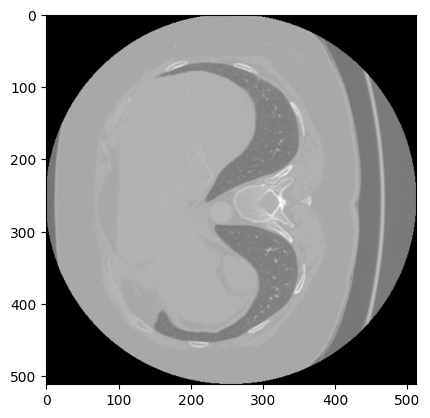

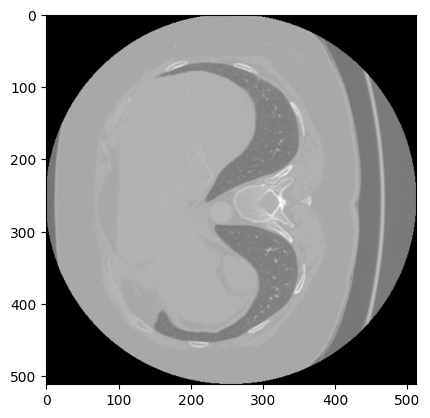

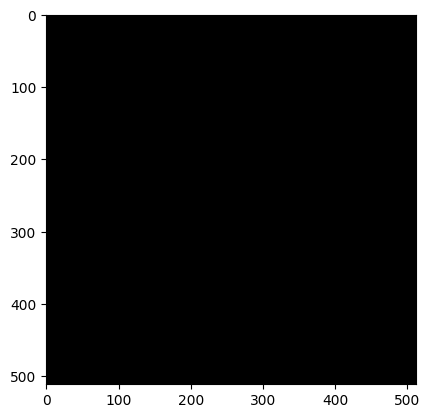

In [15]:
import SimpleITK as sitk

img_sitk = sitk.GetImageFromArray(image)
label_sitk = sitk.GetImageFromArray(label)

img_sitk.SetSpacing(spacing.tolist())
label_sitk.SetSpacing(spacing.tolist())

transform = sitk.AffineTransform(3)
transform.SetMatrix(R.flatten().tolist())

reference = sitk.Image(img_sitk.GetSize(), img_sitk.GetPixelID())
reference.SetSpacing(img_sitk.GetSpacing())
reference.SetOrigin(img_sitk.GetOrigin())


res_img = sitk.Resample(
    image1=img_sitk, 
    size = reference.GetSize(),
    transform = transform,
    interpolator = sitk.sitkLinear,
    outputOrigin = reference.GetOrigin(),
    outputSpacing = reference.GetSpacing(),
    outputDirection = reference.GetDirection(),
    defaultPixelValue = 0.0,
    outputPixelType = img_sitk.GetPixelID())

res_label = sitk.Resample(label_sitk, reference, transform, sitk.sitkNearestNeighbor, 0, label_sitk.GetPixelID())

plt.imshow(image[:,:,50], cmap="gray")
plt.show()

plt.imshow(sitk.GetArrayFromImage(img_sitk)[:,:,50], cmap="gray")
plt.show()

plt.imshow(sitk.GetArrayFromImage(res_img)[:,:,50], cmap="gray")
plt.show()

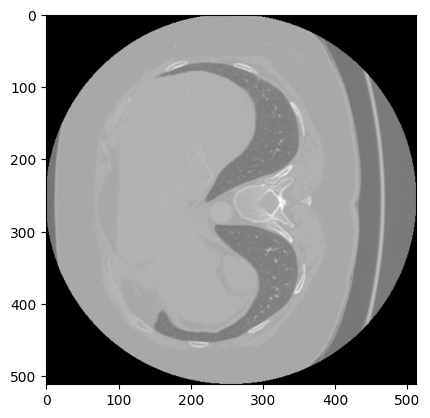

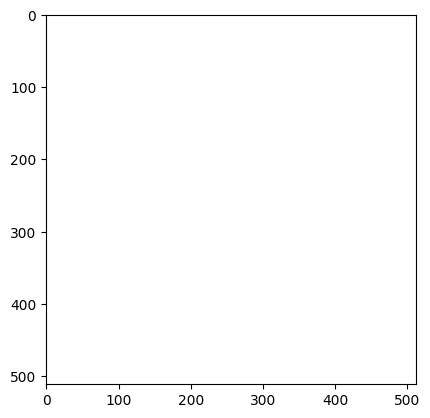

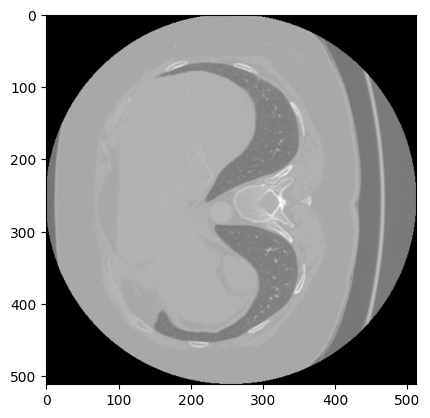

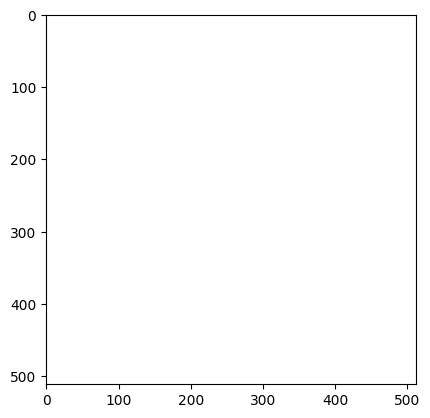

In [ ]:
affine_90 = np.array([[0, -1, 0],
                       [1,  0, 0],
                       [0,  0, 1]])
im = affine_transform(image, affine_90, order=1)
plt.imshow(image[:,:,50], cmap="gray")
plt.show()
plt.imshow(im[:,:,50], cmap="gray")
plt.show()


im2 = image[:,:,50]
im2r = affine_transform(im2, affine_90[:2,:2], order=1)
plt.imshow(im2, cmap="gray")
plt.show()
plt.imshow(im2r, cmap="gray")
plt.show()

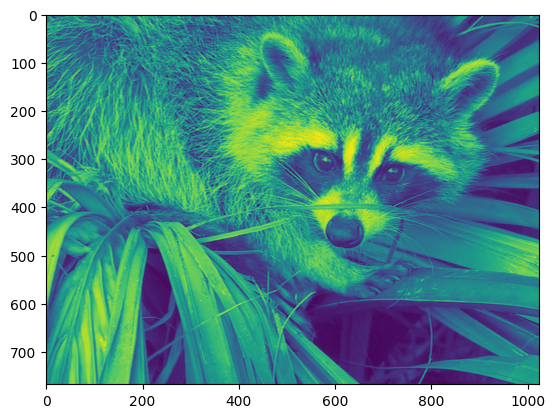

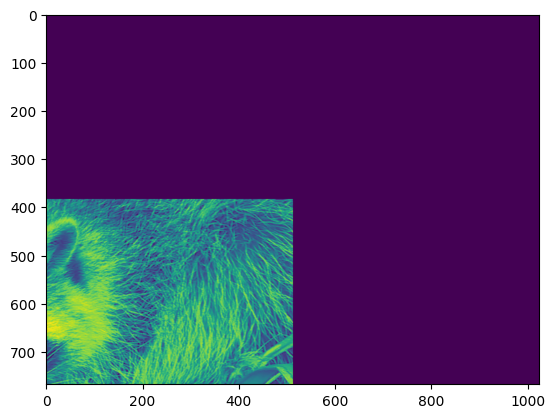

In [16]:
from scipy.ndimage import affine_transform
from scipy.datasets import face
from matplotlib import pyplot as plt
import numpy as np
im = face(gray=True)
matrix = ((1, 0), (0, -1))
offset = -im.shape[0] / 2, im.shape[1] / 2
im2 = affine_transform(im, matrix, offset=offset)
plt.imshow(im)
plt.show()
plt.imshow(im2)
plt.show()